# Interact with ERPNEXT database

In [1]:
site_dir = "/home/cole/madrid/sites"
db_name = "cole"
db = "test"

In [2]:
import os

current_dir = os.getcwd()
os.chdir(site_dir)

import frappe

frappe.connect(db, db_name=db_name)

In [3]:
import sys

sys.path.append("/home/cole/madrid/apps/inventory_tools/inventory_tools")
from inventory_tools.inventory_tools.doctype.warehouse_plan import warehouse_plan

# Explore

In [4]:
pl = frappe.get_doc("Pick List", "STO-PICK-2025-00001").as_dict()
pl

{'name': 'STO-PICK-2025-00001',
 'owner': 'Administrator',
 'creation': datetime.datetime(2025, 9, 1, 6, 43, 6, 934894),
 'modified': datetime.datetime(2025, 9, 1, 6, 43, 10, 627803),
 'modified_by': 'Administrator',
 'docstatus': 1,
 'idx': 0,
 'naming_series': 'STO-PICK-.YYYY.-',
 'company': 'Chelsea Fruit Co',
 'purpose': 'Delivery',
 'customer': 'Whole Harvest Grocery Group',
 'customer_name': 'Whole Harvest Grocery Group',
 'work_order': None,
 'material_request': None,
 'for_qty': 0.0,
 'parent_warehouse': 'All Warehouses - CFC',
 'consider_rejected_warehouses': 0,
 'pick_manually': 0,
 'ignore_pricing_rule': 0,
 'scan_barcode': None,
 'scan_mode': 0,
 'prompt_qty': 0,
 'amended_from': None,
 'group_same_items': 0,
 'status': 'Open',
 'doctype': 'Pick List',
 'locations': [{'name': 'dqef2kjfm5',
   'owner': 'Administrator',
   'creation': datetime.datetime(2025, 9, 1, 6, 43, 6, 934894),
   'modified': datetime.datetime(2025, 9, 1, 6, 43, 10, 627803),
   'modified_by': 'Administra

In [5]:
# get items in pick list doc
[item["item_code"] for item in pl["locations"]]

['Bayberry', 'Bayberry', 'Kepel', 'Lychee']

In [6]:
frappe.get_doc("Item", "Boysenberry").as_dict()

{'name': 'Boysenberry',
 'owner': 'Administrator',
 'creation': datetime.datetime(2025, 8, 29, 4, 39, 16, 291337),
 'modified': datetime.datetime(2025, 8, 29, 4, 39, 16, 327957),
 'modified_by': 'Administrator',
 'docstatus': 0,
 'idx': 0,
 'naming_series': 'STO-ITEM-.YYYY.-',
 'item_code': 'Boysenberry',
 'item_name': 'Boysenberry',
 'item_group': 'Ingredients',
 'stock_uom': 'Pound',
 'disabled': 0,
 'allow_alternative_item': 0,
 'is_stock_item': 1,
 'has_variants': 0,
 'opening_stock': 0.0,
 'valuation_rate': 0.0,
 'standard_rate': 0.0,
 'is_fixed_asset': 0,
 'auto_create_assets': 0,
 'is_grouped_asset': 0,
 'asset_category': None,
 'asset_naming_series': None,
 'over_delivery_receipt_allowance': 0.0,
 'over_billing_allowance': 0.0,
 'image': None,
 'description': 'A juicy, dark purple berry with a balance of tartness and sweetness.',
 'brand': 'Ambrosia Pie Co',
 'shelf_life_in_days': 7,
 'end_of_life': datetime.date(2099, 12, 31),
 'default_material_request_type': 'Purchase',
 'va

In [7]:
item_warehouses = frappe.get_all(
    "Bin", fields=["warehouse"], filters={"item_code": "Boysenberry"}
)
for wh in item_warehouses:
    x = frappe.get_doc("Warehouse", wh["warehouse"]).as_dict()["parent_warehouse"]
frappe.get_doc("Warehouse", "All Warehouses - APC").as_dict()

# 'parent_warehouse' == ''

{'name': 'All Warehouses - APC',
 'owner': 'Administrator',
 'creation': datetime.datetime(2025, 8, 29, 4, 38, 46, 136169),
 'modified': datetime.datetime(2025, 8, 29, 4, 38, 46, 136169),
 'modified_by': 'Administrator',
 'docstatus': 0,
 'idx': 0,
 'disabled': 0,
 'warehouse_path': None,
 'warehouse_name': 'All Warehouses',
 'is_group': 1,
 'parent_warehouse': '',
 'is_rejected_warehouse': 0,
 'account': None,
 'company': 'Ambrosia Pie Company',
 'email_id': None,
 'phone_no': None,
 'mobile_no': None,
 'address_line_1': None,
 'address_line_2': None,
 'city': None,
 'state': None,
 'pin': None,
 'warehouse_type': None,
 'default_in_transit_warehouse': None,
 'lft': 1,
 'rgt': 20,
 'old_parent': '',
 'warehouse_plan': None,
 'warehouse_plan_coordinates': None,
 'rotation': 0,
 'accessible_path': None,
 'doctype': 'Warehouse'}

## Pick List Functions

In [8]:
def get_root_warehouse(warehouse):
    # Finds closest parent warehouse with a walkable floor plan; otherwise returns None
    wh_plans = [wh["name"] for wh in frappe.get_all("Warehouse Plan")]
    if warehouse in wh_plans:
        wp_doc = frappe.get_doc("Warehouse Plan", warehouse)
        if wp_doc.as_dict()["matrix"] is not None:
            return warehouse
    parent_warehouse = frappe.get_doc("Warehouse", warehouse).as_dict()[
        "parent_warehouse"
    ]
    if parent_warehouse == "":
        return None
    return get_root_warehouse(parent_warehouse)


def get_all_warehouses(items):
    result = []
    for item_code in items:
        bins = frappe.get_all(
            "Bin", fields=["warehouse"], filters={"item_code": item_code}
        )
        for b in bins:
            result.append(
                {
                    "item_code": item_code,
                    "item_warehouses": b["warehouse"],
                    "root_warehouse": get_root_warehouse(b["warehouse"]),
                }
            )
    return result


def get_item_qty(item_code, warehouse):
    qty = frappe.db.get_value(
        "Bin", {"item_code": item_code, "warehouse": warehouse}, "actual_qty"
    )
    return qty if qty else 0


def get_node(doc, method):
    # Get root warehouse for all items in doc
    items = [item["item_code"] for item in doc["locations"]]
    root_warehouses = [get_root_warehouse(w["warehouse"]) for w in doc["locations"]]
    all_same = all(wh == root_warehouses[0] for wh in root_warehouses)
    if all_same is True:
        root_warehouse = root_warehouses[0]

    # Get all item locations for items in doctype
    # Filter by root warehouse
    item_wh_list = list(
        filter(
            lambda d: d["root_warehouse"] == root_warehouse, get_all_warehouses(items)
        )
    )
    # Item, Warehouse (in root), Qty, When Created (individial or most recent modify?)
    item_wh_qty_list = list(
        map(
            lambda d: {
                "item": d["item"],
                "warehouse": d["item_warehouses"],
                "qty": get_item_qty(d["item"], d["item_warehouses"]),
            },
            item_wh_list,
        )
    )

    if method == "FIFO":
        pass
    elif method == "LIFO":
        pass
    elif method == "Deplete maximum number of Bins":
        pass
    elif method == "Deplete minimum number of Bins":
        pass
    elif method == "Shortest Path":
        pass
    return 1

In [9]:
from erpnext.stock.report.stock_ageing.stock_ageing import FIFOSlots
from frappe.utils.data import nowdate


def get_root_warehouse(warehouse):
    # Finds closest parent warehouse with a walkable floor plan; otherwise returns None
    wh_plans = [wh["name"] for wh in frappe.get_all("Warehouse Plan")]
    if warehouse in wh_plans:
        wp_doc = frappe.get_doc("Warehouse Plan", warehouse)
        if wp_doc.as_dict()["matrix"] is not None:
            return warehouse
    parent_warehouse = frappe.get_doc("Warehouse", warehouse).as_dict()[
        "parent_warehouse"
    ]
    if parent_warehouse == "":
        return None
    return get_root_warehouse(parent_warehouse)


def get_all_warehouses(item_code):
    """Return all warehouses for a single item, including its root warehouse."""
    bins = frappe.get_all("Bin", fields=["warehouse"], filters={"item_code": item_code})
    return [
        {
            "item_code": item_code,
            "warehouse": b["warehouse"],
            "root_warehouse": get_root_warehouse(b["warehouse"]),
        }
        for b in bins
    ]


def get_item_qty(item_code, warehouse):
    """Return the actual quantity for the given item and warehouse."""
    qty = frappe.db.get_value(
        "Bin", {"item_code": item_code, "warehouse": warehouse}, "actual_qty"
    )
    return qty or 0


def get_bin_modified(item_code, warehouse):
    return frappe.db.get_value(
        "Bin",
        {"item_code": "Boysenberry", "warehouse": "Refrigerator - APC"},
        "modified",
    )


def get_node(doc, method):
    company = doc["company"]
    # Extract item codes and root warehouses from document locations
    itemdict = {}
    for loc in doc["locations"]:
        if itemdict.get(loc["item_code"]):
            itemdict[loc["item_code"]]["qty"] += loc["qty"]
        else:
            itemdict[loc["item_code"]] = {"qty": loc["qty"]}

    # Ensure all locations share the same root warehouse
    root_warehouses = [get_root_warehouse(loc["warehouse"]) for loc in doc["locations"]]
    if not all(wh == root_warehouses[0] for wh in root_warehouses):
        # Handle the case where the root warehouses differ as needed.
        return
    root_warehouse = root_warehouses[0]

    itemdict = {"Water": {"qty": 1000}}

    if method == "FIFO":

        nodes = []
        for item in itemdict:
            qty_req = itemdict[item]["qty"]
            filters = {
                "item_code": item,
                "company": company,
                "to_date": nowdate(),
            }
            fifoque = FIFOSlots(filters=filters).generate()
            qty_obt = 0
            for wh_entry_qty in fifoque[item]["fifo_queue"]:
                if (
                    get_root_warehouse(fifoque[item]["details"]["warehouse"])
                    != root_warehouse
                ):
                    continue

                if wh_entry_qty[0] > (qty_req - qty_obt):
                    nodes.append(
                        {
                            "item_code": item,
                            "warehouse": fifoque[item]["details"]["warehouse"],
                            "qty": qty_req - qty_obt,
                        }
                    )
                    break
                else:
                    nodes.append(
                        {
                            "item_code": item,
                            "warehouse": fifoque[item]["details"]["warehouse"],
                            "qty": wh_entry_qty[0],
                        }
                    )
    return nodes


get_node(pl, "FIFO")

[{'item_code': 'Water', 'warehouse': 'Fruit Storage 27 - CFC', 'qty': 15.0}]

In [10]:
pl

{'name': 'STO-PICK-2025-00001',
 'owner': 'Administrator',
 'creation': datetime.datetime(2025, 9, 1, 6, 43, 6, 934894),
 'modified': datetime.datetime(2025, 9, 1, 6, 43, 10, 627803),
 'modified_by': 'Administrator',
 'docstatus': 1,
 'idx': 0,
 'naming_series': 'STO-PICK-.YYYY.-',
 'company': 'Chelsea Fruit Co',
 'purpose': 'Delivery',
 'customer': 'Whole Harvest Grocery Group',
 'customer_name': 'Whole Harvest Grocery Group',
 'work_order': None,
 'material_request': None,
 'for_qty': 0.0,
 'parent_warehouse': 'All Warehouses - CFC',
 'consider_rejected_warehouses': 0,
 'pick_manually': 0,
 'ignore_pricing_rule': 0,
 'scan_barcode': None,
 'scan_mode': 0,
 'prompt_qty': 0,
 'amended_from': None,
 'group_same_items': 0,
 'status': 'Open',
 'doctype': 'Pick List',
 'locations': [{'name': 'dqef2kjfm5',
   'owner': 'Administrator',
   'creation': datetime.datetime(2025, 9, 1, 6, 43, 6, 934894),
   'modified': datetime.datetime(2025, 9, 1, 6, 43, 10, 627803),
   'modified_by': 'Administra

In [11]:
# items = [item["item_code"] for item in pl["locations"]]

itemdict = {}
for loc in pl["locations"]:
    if itemdict.get(loc["item_code"]):
        itemdict[loc["item_code"]]["qty"] += loc["qty"]
    else:
        itemdict[loc["item_code"]] = {"qty": loc["qty"]}
# list(itemdict.keys())

# Filter List

In [12]:
root_warehouses = [get_root_warehouse(loc["warehouse"]) for loc in pl["locations"]]
all_same = all(wh == root_warehouses[0] for wh in root_warehouses)
root_warehouse = root_warehouses[0]
all_same

True

In [13]:
frappe.db.get_value(
    "Bin", {"item_code": "Boysenberry", "warehouse": "Refrigerator - APC"}, "actual_qty"
)

# Methods

## Max Bins

In [14]:
sle = frappe.get_all(
    "Stock Ledger Entry",
    fields=["actual_qty", "posting_date", "creation", "warehouse"],
    filters={
        "item_code": "Water",
        "company": "Ambrosia Pie Company",
        "posting_date": ["<=", nowdate()],
        "is_cancelled": 0,
        "actual_qty": [">", 0],
    },
    order_by="actual_qty, posting_date, creation",
)
sle

[{'actual_qty': 50.0,
  'posting_date': datetime.date(2025, 1, 1),
  'creation': datetime.datetime(2025, 8, 29, 4, 39, 13, 587817),
  'warehouse': 'Kitchen - APC'}]

## FIFO Scratch

In [15]:
from erpnext.stock.report.stock_ageing.stock_ageing import FIFOSlots
from frappe.utils.data import nowdate

filters = {
    "item_code": "Water",
    "company": "Ambrosia Pie Company",
    "to_date": nowdate(),
}


fifoque = FIFOSlots(filters=filters).generate()
fifoque
# print(fifoque)
# fifoque["Kakadu Lime"]["fifo_queue"][0][0]
# fifoque["Kakadu Lime"]["details"]["warehouse"]

{'Water': {'details': {'name': 'Water',
   'item_name': 'Water',
   'item_group': 'Ingredients',
   'brand': 'Ambrosia Pie Co',
   'description': 'Water',
   'stock_uom': 'Cup',
   'has_serial_no': 0,
   'valuation_method': 'Moving Average',
   'actual_qty': 50.0,
   'stock_value_difference': 2.5,
   'valuation_rate': 0.05,
   'posting_date': datetime.date(2025, 1, 1),
   'voucher_type': 'Stock Entry',
   'voucher_no': 'MAT-STE-2025-00002',
   'serial_no': None,
   'batch_no': None,
   'qty_after_transaction': 50.0,
   'serial_and_batch_bundle': None,
   'warehouse': 'Kitchen - APC'},
  'fifo_queue': [[50.0, datetime.date(2025, 1, 1), 2.5]],
  'qty_after_transaction': 50.0,
  'total_qty': 50.0,
  'has_serial_no': 0}}

In [16]:
from frappe.utils import nowdate, get_datetime
import frappe
from erpnext.stock.report.stock_ageing.stock_ageing import FIFOSlots

# Define your filters
filters = {
    "item_code": "Water",
    "company": "Ambrosia Pie Company",
    "to_date": nowdate(),  # Today's date, for example
}

# Build a query for Stock Ledger Entries using frappe.qb
sle = frappe.qb.DocType("Stock Ledger Entry")
item = frappe.qb.DocType("Item")
to_date = get_datetime(filters.get("to_date") + " 23:59:59")

query = (
    frappe.qb.from_(sle)
    .from_(item)
    .select(
        item.name,
        item.item_name,
        item.item_group,
        item.brand,
        item.description,
        item.stock_uom,
        item.has_serial_no,
        item.valuation_method,
        sle.actual_qty,
        sle.stock_value_difference,
        sle.valuation_rate,
        sle.posting_date,
        sle.voucher_type,
        sle.voucher_no,
        sle.serial_no,
        sle.batch_no,
        sle.qty_after_transaction,
        sle.serial_and_batch_bundle,
        sle.warehouse,
    )
    .where(
        (sle.item_code == item.name)
        & (sle.company == filters.get("company"))
        & (sle.posting_datetime <= to_date)
        & (sle.is_cancelled != 1)
    )
)

# Execute the query and get SLEs as a list of dictionaries
results = query.run(as_dict=True)

# Pass the SLE results to FIFOSlots
fifoque = FIFOSlots(filters=filters, sle=results).generate()
fifoque["Water"]

{'details': {'name': 'Water',
  'item_name': 'Water',
  'item_group': 'Ingredients',
  'brand': 'Ambrosia Pie Co',
  'description': 'Water',
  'stock_uom': 'Cup',
  'has_serial_no': 0,
  'valuation_method': 'Moving Average',
  'actual_qty': 50.0,
  'stock_value_difference': 2.5,
  'valuation_rate': 0.05,
  'posting_date': datetime.date(2025, 1, 1),
  'voucher_type': 'Stock Entry',
  'voucher_no': 'MAT-STE-2025-00002',
  'serial_no': None,
  'batch_no': None,
  'qty_after_transaction': 50.0,
  'serial_and_batch_bundle': None,
  'warehouse': 'Kitchen - APC'},
 'fifo_queue': [[50.0, datetime.date(2025, 1, 1), 2.5]],
 'qty_after_transaction': 50.0,
 'total_qty': 50.0,
 'has_serial_no': 0}

In [17]:
from erpnext.stock.utils import get_latest_stock_qty, get_latest_stock_balance

get_latest_stock_balance()

{'Refrigerator - APC': {'Ice Water': 0.5,
  'Bayberry': 0.0,
  'Cloudberry': 0.0,
  'Butter': 0.0,
  'Tayberry': 0.0,
  'Limequat': 0.0,
  'Gooseberry': 0.0,
  'Cocoplum': 0.0,
  'Kaduka Lime': 0.0,
  'Damson Plum': 0.0,
  'Pie Crust': 0.0,
  'Ambrosia Pie Filling': 0.0,
  'Gooseberry Pie Filling': 0.0,
  'Kaduka Key Lime Pie Filling': 0.0,
  'Double Plum Pie Filling': 0.0,
  'Bayberry Pie Filling': 0.0},
 'Kitchen - APC': {'Water': 2.5},
 'Refrigerated Display - APC': {'Double Plum Pie': 0.0,
  'Ambrosia Pie': 0.0,
  'Gooseberry Pie': 0.0,
  'Pocketful of Bay': 0.0,
  'Kaduka Key Lime Pie': 0.0,
  'Tower of Bay-bel': 0.0,
  'Bayberry Pocket': 0.0,
  'Bayberry Popper': 0.0,
  'Bayberry Pie': 0.0,
  'Pie Crust': 0.0,
  'Ambrosia Pie Filling': 0.0,
  'Gooseberry Pie Filling': 0.0,
  'Kaduka Key Lime Pie Filling': 0.0,
  'Double Plum Pie Filling': 0.0,
  'Bayberry Pie Filling': 0.0},
 'Storeroom - APC': {'Pie Box': 0.0,
  'Sugar': 0.0,
  'Flour': 0.0,
  'Parchment Paper': 0.0,
  'Cornstar

In [18]:
import frappe
from frappe.utils import nowdate


def get_fifo_allocation(
    item_code: str, company: str, to_date: str, required_qty: float
):
    """
    Returns FIFO allocation for a given item as a list of dicts:
    Each dict contains:
        - 'item_code'
        - 'qty' : quantity taken from that FIFO bin
        - 'warehouse' : warehouse from which stock was allocated

    Uses frappe.get_all to fetch SLE records in FIFO order.
    """
    # Query positive (incoming) SLE records for the given item using the ORM
    bins = frappe.get_all(
        "Stock Ledger Entry",
        fields=[
            "actual_qty",
            "valuation_rate",
            "posting_date",
            "creation",
            "warehouse",
        ],
        filters={
            "item_code": item_code,
            "company": company,
            "posting_date": ["<=", to_date],
            "is_cancelled": 0,
            "actual_qty": [">", 0],
        },
        order_by="posting_date, creation",
    )

    allocation = []
    remaining = required_qty

    # Process each incoming stock bin in FIFO order
    for bin in bins:
        if remaining <= 0:
            break

        available = bin.get("actual_qty", 0)
        allocated_qty = min(available, remaining)
        allocation.append(
            {
                "item_code": item_code,
                "qty": allocated_qty,
                "warehouse": bin.get("warehouse"),
            }
        )
        remaining -= allocated_qty

    if remaining > 0:
        frappe.msgprint(f"Warning: Not enough stock. Short by {remaining}")

    return allocation


# --- Example Usage ---
item_code = "Water"
company = "Ambrosia Pie Company"
to_date = nowdate()  # or specify a date string (e.g., "2025-03-06")
required_qty = 150  # specify the consumption quantity

fifo_allocation = get_fifo_allocation(item_code, company, to_date, required_qty)
print("FIFO Allocation:", fifo_allocation)

FIFO Allocation: [{'item_code': 'Water', 'qty': 50.0, 'warehouse': 'Kitchen - APC'}]


In [19]:
# v2 final final final

sle = frappe.get_all(
    "Stock Ledger Entry",
    fields=["actual_qty", "posting_date", "creation", "warehouse"],
    filters={
        "item_code": "Water",
        "company": "Ambrosia Pie Company",
        "posting_date": ["<=", nowdate()],
        "is_cancelled": 0,
        "actual_qty": [">", 0],
    },
    order_by="posting_date, creation",
)
sle

[{'actual_qty': 50.0,
  'posting_date': datetime.date(2025, 1, 1),
  'creation': datetime.datetime(2025, 8, 29, 4, 39, 13, 587817),
  'warehouse': 'Kitchen - APC'}]

## FIFO final final v2

In [20]:
class Rules:
    @staticmethod
    def _process_entries(item_code, qty, company, order_by, root_warehouse, to_date):
        # Retrieve stock ledger entries with the provided filters and ordering.
        sle = frappe.get_all(
            "Stock Ledger Entry",
            fields=["actual_qty", "posting_date", "creation", "warehouse"],
            filters={
                "item_code": item_code,
                "company": company,
                "posting_date": ["<=", to_date],
                "is_cancelled": 0,
                "actual_qty": [">", 0],
            },
            order_by=order_by,
        )

        newsle = []
        qty_obtained = 0

        # Process each entry until the required quantity is fulfilled.
        for entry in sle:
            # If a root warehouse is specified, ensure the entry belongs to it.
            if (
                root_warehouse
                and get_root_warehouse(entry["warehouse"]) != root_warehouse
            ):
                continue

            remaining_qty = qty - qty_obtained

            if entry["actual_qty"] > remaining_qty:
                newsle.append(
                    {
                        "item_code": item_code,
                        "warehouse": entry["warehouse"],
                        "qty": remaining_qty,
                    }
                )
                qty_obtained += remaining_qty
                break
            else:
                newsle.append(
                    {
                        "item_code": item_code,
                        "warehouse": entry["warehouse"],
                        "qty": entry["actual_qty"],
                    }
                )
                qty_obtained += entry["actual_qty"]

        # If the accumulated quantity doesn't match the requested quantity, raise an error.
        if (qty - qty_obtained) != 0:
            raise frappe.ValidationError("Not enough items in root warehouse")
        return newsle

    @staticmethod
    def FIFO(item_code, qty, company, root_warehouse=None, to_date=nowdate()):
        # FIFO: Order by posting_date and creation in ascending order.
        return Rules._process_entries(
            item_code, qty, company, "posting_date, creation", root_warehouse, to_date
        )

    @staticmethod
    def LIFO(item_code, qty, company, root_warehouse=None, to_date=nowdate()):
        # LIFO: Order by posting_date and creation in descending order.
        return Rules._process_entries(
            item_code,
            qty,
            company,
            "posting_date desc, creation desc",
            root_warehouse,
            to_date,
        )

In [21]:
pl

{'name': 'STO-PICK-2025-00001',
 'owner': 'Administrator',
 'creation': datetime.datetime(2025, 9, 1, 6, 43, 6, 934894),
 'modified': datetime.datetime(2025, 9, 1, 6, 43, 10, 627803),
 'modified_by': 'Administrator',
 'docstatus': 1,
 'idx': 0,
 'naming_series': 'STO-PICK-.YYYY.-',
 'company': 'Chelsea Fruit Co',
 'purpose': 'Delivery',
 'customer': 'Whole Harvest Grocery Group',
 'customer_name': 'Whole Harvest Grocery Group',
 'work_order': None,
 'material_request': None,
 'for_qty': 0.0,
 'parent_warehouse': 'All Warehouses - CFC',
 'consider_rejected_warehouses': 0,
 'pick_manually': 0,
 'ignore_pricing_rule': 0,
 'scan_barcode': None,
 'scan_mode': 0,
 'prompt_qty': 0,
 'amended_from': None,
 'group_same_items': 0,
 'status': 'Open',
 'doctype': 'Pick List',
 'locations': [{'name': 'dqef2kjfm5',
   'owner': 'Administrator',
   'creation': datetime.datetime(2025, 9, 1, 6, 43, 6, 934894),
   'modified': datetime.datetime(2025, 9, 1, 6, 43, 10, 627803),
   'modified_by': 'Administra

# Testing

In [22]:
from inventory_tools.inventory_tools.overrides.pick_list import (
    optimize_path,
    optimize_route_picklist,
)
from pprint import pprint

methods = [
    "FIFO",
    "LIFO",
    "Deplete maximum number of Bins",
    "Deplete minimum number of Bins",
]
for m in methods:
    print(f"Method: {m}")
    # out = optimize_path(pl, m)
    out = optimize_path("STO-PICK-2025-00001", m)
    pprint(out)

Method: FIFO
[{'item_code': 'Bayberry', 'qty': 17.0, 'warehouse': 'Fruit Storage 11 - CFC'},
 {'item_code': 'Bayberry', 'qty': 3.0, 'warehouse': 'Fruit Storage 14 - CFC'},
 {'item_code': 'Kepel', 'qty': 12.0, 'warehouse': 'Fruit Storage 21 - CFC'},
 {'item_code': 'Lychee', 'qty': 3.0, 'warehouse': 'Fruit Storage 49 - CFC'}]
Method: LIFO
[{'item_code': 'Bayberry', 'qty': 20.0, 'warehouse': 'Fruit Storage 57 - CFC'},
 {'item_code': 'Kepel', 'qty': 12.0, 'warehouse': 'Fruit Storage 45 - CFC'},
 {'item_code': 'Lychee', 'qty': 3.0, 'warehouse': 'Fruit Storage 25 - CFC'}]
Method: Deplete maximum number of Bins
[{'item_code': 'Bayberry', 'qty': 10.0, 'warehouse': 'Fruit Storage 34 - CFC'},
 {'item_code': 'Lychee', 'qty': 3.0, 'warehouse': 'Fruit Storage 25 - CFC'},
 {'item_code': 'Kepel', 'qty': 12.0, 'warehouse': 'Fruit Storage 21 - CFC'},
 {'item_code': 'Bayberry', 'qty': 10.0, 'warehouse': 'Fruit Storage 11 - CFC'}]
Method: Deplete minimum number of Bins
[{'item_code': 'Bayberry', 'qty': 2

In [23]:
optimize_route_picklist(out, "All Warehouses - CFC")

[{'item_code': 'Bayberry', 'warehouse': 'Fruit Storage 57 - CFC', 'qty': 20.0},
 {'item_code': 'Kepel', 'warehouse': 'Fruit Storage 45 - CFC', 'qty': 12.0},
 {'item_code': 'Lychee', 'warehouse': 'Fruit Storage 49 - CFC', 'qty': 3.0}]

In [24]:
from inventory_tools.inventory_tools.overrides.pick_list import (
    optimize_path,
    optimize_route_picklist,
)
from inventory_tools.inventory_tools.doctype.warehouse_plan.warehouse_plan import (
    Grid_TSP,
)
from frappe.utils import safe_json_loads
from pprint import pprint
import numpy as np

# Stock for the following items:
# {'Tower of Bay-bel': 'MFG-WO-2025-00005',
#  'Pocketful of Bay': 'MFG-WO-2025-00006',
#  'Bayberry Pie': 'MFG-WO-2025-00012',
#  'Bayberry Pocket': 'MFG-WO-2025-00014',
#  'Bayberry Popper': 'MFG-WO-2025-00015'}

# Bayberry popper
# Create work order: MFG-WO-2025-00017
# Create pick list: STO-PICK-2025-00002
pl = frappe.get_doc("Pick List", "STO-PICK-2025-00001").as_dict()
grid = np.array(
    safe_json_loads(
        frappe.get_doc("Warehouse Plan", "All Warehouses - CFC").as_dict()["matrix"]
    )
)

In [25]:
import pyperclip

pyperclip.copy(
    safe_json_loads(
        frappe.get_doc("Warehouse Plan", "All Warehouses - CFC").as_dict()["matrix"]
    )
)

In [26]:
out

[{'item_code': 'Bayberry', 'warehouse': 'Fruit Storage 57 - CFC', 'qty': 20.0},
 {'item_code': 'Kepel', 'warehouse': 'Fruit Storage 45 - CFC', 'qty': 12.0},
 {'item_code': 'Lychee', 'warehouse': 'Fruit Storage 49 - CFC', 'qty': 3.0}]

In [27]:
optimize_route_picklist(out, "All Warehouses - CFC")

[{'item_code': 'Bayberry', 'warehouse': 'Fruit Storage 57 - CFC', 'qty': 20.0},
 {'item_code': 'Kepel', 'warehouse': 'Fruit Storage 45 - CFC', 'qty': 12.0},
 {'item_code': 'Lychee', 'warehouse': 'Fruit Storage 49 - CFC', 'qty': 3.0}]

In [28]:
# Get Grid
import numpy as np
from frappe.utils import safe_json_loads

root_warehouse = "All Warehouses - CFC"
grid = np.array(
    safe_json_loads(
        frappe.get_doc("Warehouse Plan", root_warehouse).as_dict()["matrix"]
    )
)
grid

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(32, 50))

In [29]:
# get scale
import numpy as np

imaginary_x = grid.shape[1]

real_x = frappe.get_doc("Warehouse Plan", root_warehouse).as_dict()["horizontal"]

scale = real_x / imaginary_x
scale

1.0

In [30]:
out

[{'item_code': 'Bayberry', 'warehouse': 'Fruit Storage 57 - CFC', 'qty': 20.0},
 {'item_code': 'Kepel', 'warehouse': 'Fruit Storage 45 - CFC', 'qty': 12.0},
 {'item_code': 'Lychee', 'warehouse': 'Fruit Storage 49 - CFC', 'qty': 3.0}]

In [31]:
# get waypoints
item_whs = out
unique_whs = list({item_wh["warehouse"] for item_wh in item_whs})
waypoints = []
for wh in unique_whs:
    loc = frappe.get_doc("Warehouse", wh).as_dict()
    waypoints.append({wh: (loc["accessible_path"])})
waypoints

[{'Fruit Storage 45 - CFC': '32,13'},
 {'Fruit Storage 57 - CFC': '41,10'},
 {'Fruit Storage 49 - CFC': '35,6'}]

In [32]:
frappe.get_doc("Warehouse Plan", "All Warehouses - CFC").as_dict()

{'name': 'All Warehouses - CFC',
 'owner': 'Administrator',
 'creation': datetime.datetime(2025, 8, 29, 4, 39, 1, 894625),
 'modified': datetime.datetime(2025, 8, 30, 10, 39, 2, 763364),
 'modified_by': 'Administrator',
 'docstatus': 0,
 'idx': 0,
 'horizontal': 50.0,
 'vertical': 32.0,
 'uom': 'Meter',
 'offset': '1,1,2.2,1',
 'company': 'Chelsea Fruit Co',
 'group_warehouse': 'All Warehouses - CFC',
 'floor_plan': '/files/warehouse_plan.png',
 'pickup_point_x': 0,
 'pickup_point_y': 9,
 'matrix': '[[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,0,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,1,0,0,0,1,1,1,1,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,1,0,0,0,1,1,1,1,0,0,1,1,1,1,0,0,1,1,0,0,0

In [33]:
root_wh = frappe.get_doc("Warehouse Plan", "All Warehouses - CFC").as_dict()
(root_wh["pickup_point_x"], root_wh["pickup_point_y"])

(0, 9)

# Documentation

In [34]:
def optimize_route_picklist_debug(item_whs: list, root_warehouse: str) -> list:
    """Optimize the pick-up route for a list of items.

    This function takes a list of dictionaries, each representing an item along with its warehouse
    location, and returns the list reordered based on an optimized pick-up sequence.

    Expected format of `item_whs`:
            [
                    {
                            'item_code': <str>,   # The code identifying the item.
                            'warehouse': <str>    # The warehouse where the item is located.
                    },
                    ...
            ]

    Returns:
            list: A reordered list of dictionaries, optimized for the pick-up route.
    """

    # Grid
    grid = np.array(
        safe_json_loads(
            frappe.get_doc("Warehouse Plan", root_warehouse).as_dict()["matrix"]
        )
    )

    # Scale
    imaginary_x = grid.shape[1]
    real_x = frappe.get_doc("Warehouse Plan", root_warehouse).as_dict()["horizontal"]
    scale = real_x / imaginary_x

    # Create the TSP solver instance.
    g = Grid_TSP(grid, scale=scale)

    root_wh = frappe.get_doc("Warehouse Plan", "All Warehouses - CFC").as_dict()
    dropoff = [g.pos2node((root_wh["pickup_point_x"], root_wh["pickup_point_y"]))]

    # Waypoints
    unique_whs = list({item_wh["warehouse"] for item_wh in item_whs})

    # Build a mapping from warehouse to its coordinate and node.
    warehouse_to_node = {}
    for wh in unique_whs:
        accessible_path = (
            frappe.get_doc("Warehouse", wh).as_dict()["accessible_path"].split(",")
        )
        coordinate = (int(accessible_path[0]), int(accessible_path[1]))
        warehouse_to_node[wh] = g.pos2node(coordinate)
    node_to_warehouse = {node: wh for wh, node in warehouse_to_node.items()}

    # For the TSP solver, create a list of nodes corresponding to each unique warehouse.
    pickup_list = list(warehouse_to_node.values())

    # Solve
    pickup_order, *rest = g.tsp(dropoff, pickup_list, True)

    # Map warehouse name to its order
    warehouse_order_map = {}
    for order_index, node in enumerate(pickup_order):
        wh = node_to_warehouse[node]
        warehouse_order_map[wh] = order_index

    # Sort original item_whs
    sorted_item_whs = sorted(
        item_whs,
        key=lambda item: (
            warehouse_order_map[item["warehouse"]],
            item["item_code"],
            item["qty"],
        ),
    )
    return rest

Method: FIFO
[{'item_code': 'Bayberry', 'qty': 17.0, 'warehouse': 'Fruit Storage 11 - CFC'},
 {'item_code': 'Bayberry', 'qty': 3.0, 'warehouse': 'Fruit Storage 14 - CFC'},
 {'item_code': 'Kepel', 'qty': 12.0, 'warehouse': 'Fruit Storage 21 - CFC'},
 {'item_code': 'Lychee', 'qty': 3.0, 'warehouse': 'Fruit Storage 49 - CFC'}]
[[450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 509, 559, 609, 659, 709, 759, 809, 810, 811, 812, 813, 763, 713, 663, 613, 563, 513, 463, 464, 465, 464, 514, 564, 614, 664, 714, 764, 814, 815, 816, 817, 818, 819, 820, 770, 720, 719, 669, 619, 569, 519, 469, 419, 369, 319, 269, 219, 169, 119, 69, 70, 71, 72, 71, 70, 120, 170, 220, 270, 320, 370, 420, 470, 520, 570, 620, 670, 720, 770, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 784, 734, 684, 634, 584, 534, 484, 434, 384, 334, 335, 334, 384, 434, 484, 534, 584, 634, 684, 734, 784, 834, 833, 832, 831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 820, 819, 818, 817, 816, 815, 814

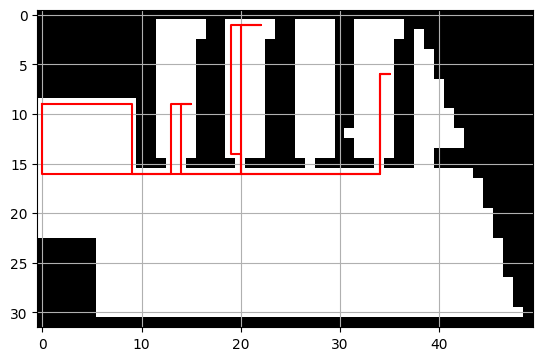

None
Method: LIFO
[{'item_code': 'Bayberry', 'qty': 20.0, 'warehouse': 'Fruit Storage 57 - CFC'},
 {'item_code': 'Kepel', 'qty': 12.0, 'warehouse': 'Fruit Storage 45 - CFC'},
 {'item_code': 'Lychee', 'qty': 3.0, 'warehouse': 'Fruit Storage 25 - CFC'}]
[[450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 509, 559, 609, 659, 709, 759, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 788, 738, 688, 638, 588, 538, 539, 540, 541, 540, 539, 538, 588, 638, 688, 738, 788, 838, 837, 836, 835, 834, 784, 734, 733, 732, 682, 683, 684, 734, 784, 834, 833, 832, 831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 820, 770, 720, 670, 620, 570, 571, 572, 571, 570, 620, 670, 720, 770, 820, 819, 818, 817, 816, 815, 814, 813, 812, 811, 810, 809, 808, 807, 806, 805, 804, 803, 802, 801, 800, 750, 700, 650, 600, 550, 500, 450], 132.0]


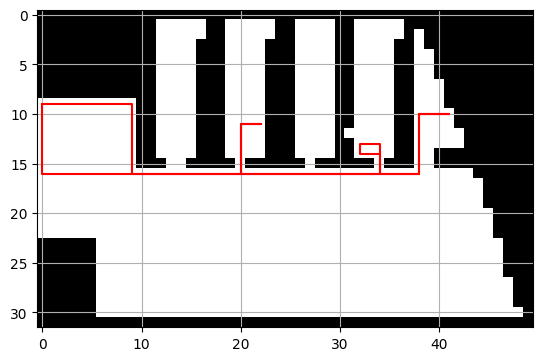

None
Method: Deplete maximum number of Bins
[{'item_code': 'Bayberry', 'qty': 10.0, 'warehouse': 'Fruit Storage 34 - CFC'},
 {'item_code': 'Lychee', 'qty': 3.0, 'warehouse': 'Fruit Storage 25 - CFC'},
 {'item_code': 'Kepel', 'qty': 12.0, 'warehouse': 'Fruit Storage 21 - CFC'},
 {'item_code': 'Bayberry', 'qty': 10.0, 'warehouse': 'Fruit Storage 11 - CFC'}]
[[450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 509, 559, 609, 659, 709, 759, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 777, 727, 677, 627, 577, 527, 477, 427, 377, 327, 277, 227, 177, 127, 77, 78, 79, 78, 77, 127, 177, 227, 277, 327, 377, 427, 477, 527, 577, 627, 677, 727, 777, 827, 826, 825, 824, 823, 822, 821, 820, 770, 720, 670, 620, 570, 571, 572, 522, 472, 422, 372, 322, 272, 222, 172, 122, 72, 71, 70, 120, 170, 220, 270, 320, 370, 420, 470, 520, 570, 620, 670, 720, 770, 820, 819, 818, 817, 816, 815, 814, 764, 714, 664, 614, 564, 514, 464, 465, 464, 463, 513, 563, 613, 663

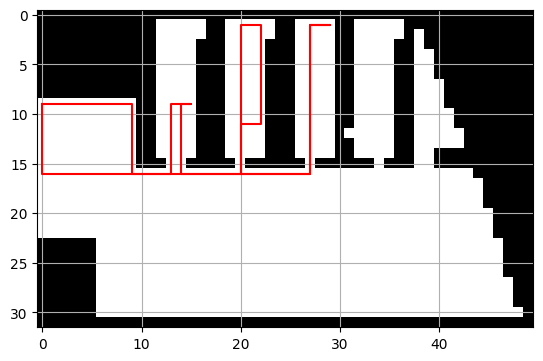

None
Method: Deplete minimum number of Bins
[{'item_code': 'Bayberry', 'qty': 20.0, 'warehouse': 'Fruit Storage 57 - CFC'},
 {'item_code': 'Kepel', 'qty': 12.0, 'warehouse': 'Fruit Storage 45 - CFC'},
 {'item_code': 'Lychee', 'qty': 3.0, 'warehouse': 'Fruit Storage 49 - CFC'}]
[[450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 509, 559, 609, 659, 709, 759, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 788, 738, 688, 638, 588, 538, 539, 540, 541, 540, 539, 538, 588, 638, 688, 738, 788, 838, 837, 836, 835, 834, 784, 734, 733, 732, 682, 632, 582, 532, 482, 432, 382, 332, 333, 334, 335, 334, 384, 434, 484, 534, 584, 634, 684, 734, 784, 834, 833, 832, 831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 820, 819, 818, 817, 816, 815, 814, 813, 812, 811, 810, 809, 808, 807, 806, 805, 804, 803, 802, 801, 800, 750, 700, 650, 600, 550, 500, 450], 134.0]


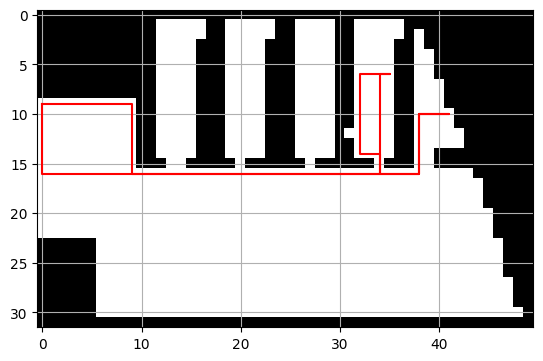

None


In [35]:
from inventory_tools.inventory_tools.overrides.pick_list import (
    optimize_path,
    optimize_route_picklist,
)
import frappe
from frappe.utils import safe_json_loads
from frappe.utils.data import nowdate
import numpy as np
from inventory_tools.inventory_tools.doctype.warehouse_plan.warehouse_plan import (
    Grid_TSP,
)
from pprint import pprint

methods = [
    "FIFO",
    "LIFO",
    "Deplete maximum number of Bins",
    "Deplete minimum number of Bins",
]
root_warehouse = "All Warehouses - CFC"
grid = np.array(
    safe_json_loads(
        frappe.get_doc("Warehouse Plan", root_warehouse).as_dict()["matrix"]
    )
)
for m in methods:
    print(f"Method: {m}")
    # out = optimize_path(pl, m)
    optimized = optimize_path("STO-PICK-2025-00001", m)
    pprint(optimized)
    out = optimize_route_picklist_debug(optimized, root_warehouse)
    print(out)
    print(Grid_TSP(grid)._plot(out[0]))